# Exploratory Data Analysis (EDA) for Model Training Dataset


## 1.Setup and Data Loading

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.feature_selection import VarianceThreshold

In [2]:
# define paths
training_data_path = '../../data/processed/model_input_dataset.csv'

In [3]:
# load data
df = pd.read_csv(training_data_path)

## Dataset Feature Description

| Feature | Description |
|--------|-------------|
| `LONGITUDE`, `LATITUDE` | Geographic coordinates of the sample point in WGS84 (EPSG:4326). |
| `LABEL` | Binary classification target: `1` = porphyry copper sample (positive), `0` = negative sample (non-porphyry). |
| `gravity_iso_residual`, `gravity_cscba`, `gravity_cscba_1vd` | Gravity anomaly measures from various processing techniques: isostatic residuals, complete Bouguer anomaly, and first vertical derivative. |
| `gravity_iso_residual_stddev3x3`, `gravity_cscba_stddev3x3` | Local texture features showing spatial variation (standard deviation) of gravity anomalies in a 3x3 pixel neighborhood. |
| `mag_uc_1_2km` to `mag_uc_12_16km` | Upward-continued magnetic anomalies at increasing depth intervals (1–2 km to 12–16 km), representing magnetic responses at different crustal depths. |
| `mag_uc_2_4km_1vd`, `mag_uc_2_4km_thd` | Vertical derivative (1VD) and total horizontal derivative (THD) of the magnetic field at 2–4 km, emphasizing edges and transitions in subsurface magnetism. |
| `mag_uc_2_4km_stddev3x3` | Local standard deviation of magnetic field at 2–4 km, capturing texture and localized anomalies. |
| `radio_K_pct`, `radio_Th_ppm`, `radio_U_ppm` | Radiometric concentrations of Potassium (%), Thorium (ppm), and Uranium (ppm), typically measured via airborne gamma-ray spectrometry. |
| `radio_Th_K_ratio`, `radio_U_K_ratio`, `radio_U_Th_ratio` | Derived ratios between radiometric bands, often used to indicate geochemical alteration zones (e.g., potassium enrichment or thorium depletion). |

---

## Summary

- This dataset integrates multi-modal geoscience inputs from **gravity**, **magnetic**, and **radiometric** imagery, including **derived** and **texture** features.
- Each row represents a georeferenced sample point with a known deposit classification (`LABEL`), enabling **supervised machine learning**.
- There is **class imbalance** between positive (label = 1) and negative samples, which may require strategies like weighted loss, resampling, or SMOTE during training.
- The inclusion of **vertical derivatives (1VD)** and **horizontal gradients (THD)** provides enhanced sensitivity to geophysical edges and anomalies often linked to porphyry systems.


In [4]:
# initial inspection
df.head()

,LONGITUDE,LATITUDE,LABEL,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,gravity_iso_residual_stddev3x3,gravity_cscba_stddev3x3,mag_uc_1_2km,mag_uc_2_4km,...,mag_uc_12_16km,mag_uc_2_4km_1vd,mag_uc_2_4km_thd,mag_uc_2_4km_stddev3x3,radio_K_pct,radio_Th_ppm,radio_U_ppm,radio_Th_K_ratio,radio_U_K_ratio,radio_U_Th_ratio
0,145.277695,-34.107134,0,52.223591,349.392853,-40.59006,0.752113,37.011612,0.584576,0.992970,...,1.204403,-0.000780,0.001489,0.038044,1.104598,10.030174,1.367533,9.082856,1.238717,0.136452
1,125.714108,-23.943929,0,-195.990967,-534.088440,-556.97266,2.474874,47.704494,3.931087,5.403521,...,-0.071080,-0.013591,0.021547,0.549094,0.158148,15.495625,1.302552,77.478119,6.512759,0.084177
2,148.821727,-21.846854,1,376.498871,-531.526184,198.01955,0.918559,46.138040,-15.808146,0.000513,...,-2.160016,-0.091868,0.096375,2.462595,0.327474,3.212502,0.507891,9.933004,1.592497,0.159617
3,134.851273,-19.145144,0,10.045643,-709.562378,-201.86922,1.362985,60.546470,-12.336065,-17.813541,...,-10.113371,0.025990,0.028927,0.738085,0.281605,7.375026,0.806524,26.118765,2.877724,0.111031
4,142.587968,-28.984738,0,-34.105846,114.804726,-124.66106,2.218750,87.284930,-2.577452,-4.013026,...,-2.264580,-0.006811,0.014678,0.374207,0.442369,3.287470,0.641557,7.432631,1.465061,0.198236


In [5]:
# Check data types, non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4929 entries, 0 to 4928
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LONGITUDE                       4929 non-null   float64
 1   LATITUDE                        4929 non-null   float64
 2   LABEL                           4929 non-null   int64  
 3   gravity_iso_residual            4923 non-null   float64
 4   gravity_cscba                   4928 non-null   float64
 5   gravity_cscba_1vd               4929 non-null   float64
 6   gravity_iso_residual_stddev3x3  4929 non-null   float64
 7   gravity_cscba_stddev3x3         4929 non-null   float64
 8   mag_uc_1_2km                    4929 non-null   float64
 9   mag_uc_2_4km                    4929 non-null   float64
 10  mag_uc_4_8km                    4929 non-null   float64
 11  mag_uc_8_12km                   4929 non-null   float64
 12  mag_uc_12_16km                  49

In [6]:
# Identify feature columns, coordinate columns, target column
df.columns

Index(['LONGITUDE', 'LATITUDE', 'LABEL', 'gravity_iso_residual',
       'gravity_cscba', 'gravity_cscba_1vd', 'gravity_iso_residual_stddev3x3',
       'gravity_cscba_stddev3x3', 'mag_uc_1_2km', 'mag_uc_2_4km',
       'mag_uc_4_8km', 'mag_uc_8_12km', 'mag_uc_12_16km', 'mag_uc_2_4km_1vd',
       'mag_uc_2_4km_thd', 'mag_uc_2_4km_stddev3x3', 'radio_K_pct',
       'radio_Th_ppm', 'radio_U_ppm', 'radio_Th_K_ratio', 'radio_U_K_ratio',
       'radio_U_Th_ratio'],
      dtype='object')

In [7]:
# Get basic statistics for numerical features
df.describe()

,LONGITUDE,LATITUDE,LABEL,gravity_iso_residual,gravity_cscba,gravity_cscba_1vd,gravity_iso_residual_stddev3x3,gravity_cscba_stddev3x3,mag_uc_1_2km,mag_uc_2_4km,...,mag_uc_12_16km,mag_uc_2_4km_1vd,mag_uc_2_4km_thd,mag_uc_2_4km_stddev3x3,radio_K_pct,radio_Th_ppm,radio_U_ppm,radio_Th_K_ratio,radio_U_K_ratio,radio_U_Th_ratio
count,4929.000000,4929.000000,4929.000000,4923.000000,4928.000000,4929.000000,4929.000000,4929.000000,4929.000000,4929.000000,...,4929.000000,4929.000000,4929.000000,4929.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000,4700.000000
mean,137.287744,-24.932006,0.192737,-4.432279,-287.023978,-256.665960,2.749666,90.235735,3.537176,5.424153,...,3.643083,-0.002980,0.059936,1.536775,0.749988,9.054721,1.110049,19.471643,2.292501,0.144366
std,8.753279,5.037019,0.394488,251.459051,1322.359843,307.564372,68.255388,128.853113,33.313871,38.229016,...,19.187696,0.074151,0.101362,2.589747,0.608717,5.989344,0.526907,24.778277,1.968572,0.086693
min,114.752437,-42.978509,0.000000,-1194.755981,-7671.638672,-1561.360100,0.000000,0.000000,-173.130650,-161.741930,...,-65.823900,-0.807918,0.000000,0.000000,-0.079312,-0.340388,-0.431995,0.295228,0.000000,0.000000
25%,130.635916,-27.918855,0.000000,-139.990829,-950.397644,-384.031980,0.789952,23.722393,-7.519691,-10.079520,...,-6.647484,-0.011665,0.007562,0.195688,0.307348,5.429582,0.767855,7.911652,1.070115,0.107993
50%,137.272770,-24.616022,0.000000,24.334196,-247.025520,-186.579730,1.366004,50.137165,-1.178985,-1.300108,...,-0.501992,-0.000111,0.020253,0.521408,0.599062,7.696463,1.025099,11.763362,1.700443,0.132910
75%,145.255623,-21.279825,0.000000,170.551384,418.018776,-68.424600,2.283603,104.801600,6.343928,10.644053,...,8.971527,0.009688,0.063248,1.622904,0.988600,10.704035,1.339246,20.861480,2.909476,0.164196
max,152.422815,-12.306903,1.000000,944.520447,9075.992188,607.795300,4792.627000,2271.849900,440.274700,530.098270,...,131.554150,0.625214,1.199163,30.538845,4.745244,89.899788,7.338193,377.172974,32.714317,2.750361


## 2.Exploratory Data Analysis (EDA)

### 2.1. Target Variable Analysis

In [8]:
# Check class distribution (imbalance)
df['LABEL'].value_counts()

LABEL
0    3979
1     950
Name: count, dtype: int64

<Axes: title={'center': 'Class Balance'}, xlabel='LABEL'>

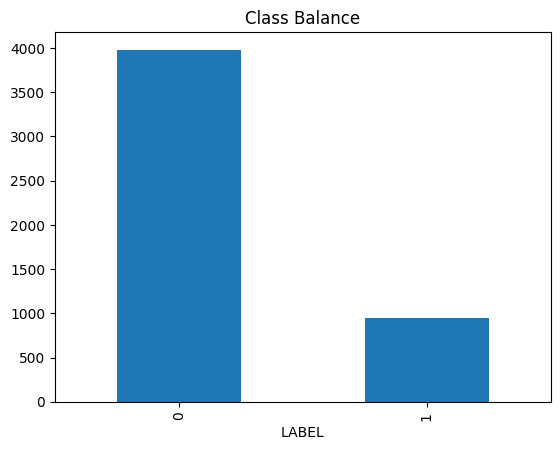

In [9]:
# Class distribution
df['LABEL'].value_counts().plot(kind='bar', title='Class Balance')

### 2.2. Feature Distribution Analysis


In [11]:
# Exclude non-numeric columns and non feature columns
feature_cols = df.drop(columns=['LONGITUDE', 'LATITUDE', 'LABEL']).select_dtypes(include='number').columns

#### 2.2.1. KDE Plots (kernel density estimate (KDE) plot)

The following observations are based on kernel density plots of all input features grouped by class label (`LABEL`: 1 = porphyry copper deposit, 0 = non-deposit). This helps assess separability, skewness.

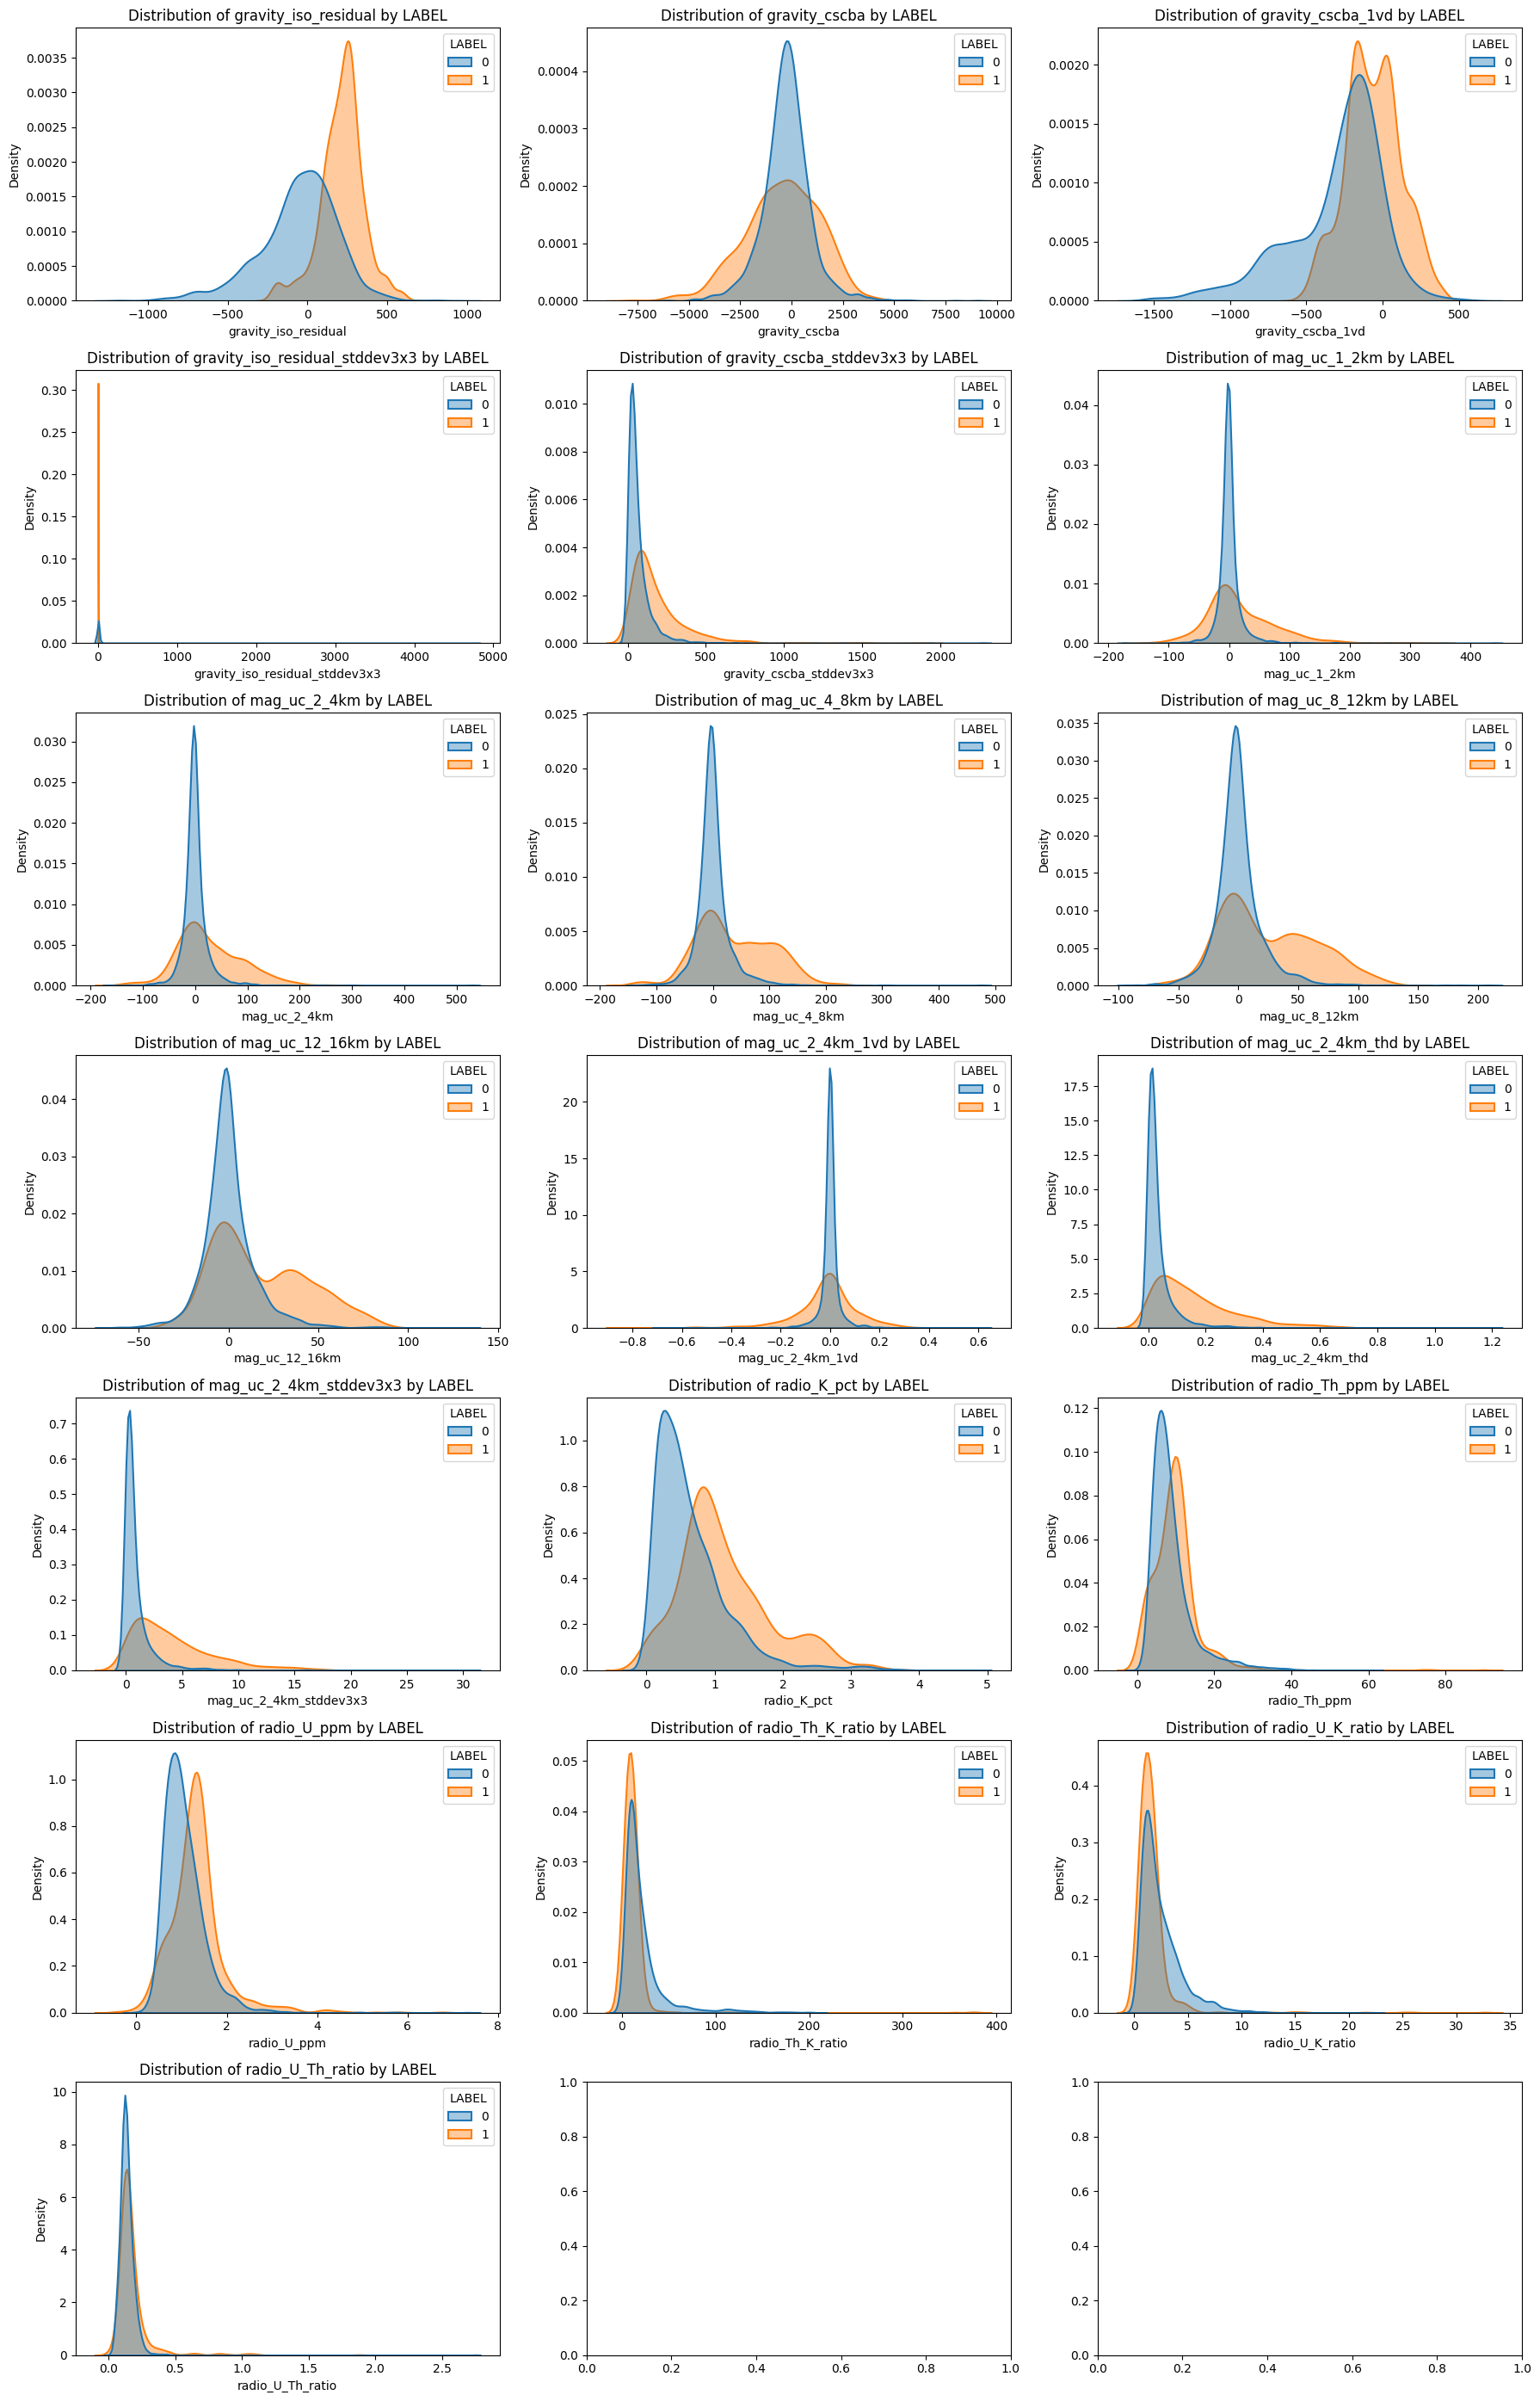

In [12]:
# KDEs: Plot distributions for all numerical features. Grouping by LABEL.
num_features = len(feature_cols)
cols = 3
rows = math.ceil(num_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()
for i, feature in enumerate(feature_cols):
    sns.kdeplot(data=df, x=feature, hue='LABEL', fill=True, common_norm=False, alpha=0.4, linewidth=1.5, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by LABEL', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

#### 2.2.2. Skewness

We examined the skewness of all numerical features to understand their distributional asymmetry. 

Skewness values greater than |1| typically indicate a highly skewed (non-normal) distribution, which may affect the performance of certain machine learning models, especially those that assume feature symmetry (e.g., logistic regression).


In [13]:
# Skewness: Calculate and display skewness for each feature.
skewness = df[feature_cols].skew().sort_values(ascending=False)
print("Feature Skewness:\n", skewness)

Feature Skewness:
 gravity_iso_residual_stddev3x3    70.156501
radio_U_Th_ratio                  10.937788
gravity_cscba_stddev3x3            5.469960
radio_Th_K_ratio                   4.862808
radio_U_K_ratio                    3.578119
mag_uc_2_4km_thd                   3.479102
mag_uc_2_4km_stddev3x3             3.464946
mag_uc_1_2km                       3.116664
radio_Th_ppm                       3.101142
radio_U_ppm                        2.707418
mag_uc_2_4km                       2.349466
mag_uc_4_8km                       1.716359
radio_K_pct                        1.686703
mag_uc_8_12km                      1.546832
mag_uc_12_16km                     1.419992
gravity_cscba                     -0.068240
gravity_iso_residual              -0.709879
gravity_cscba_1vd                 -1.081087
mag_uc_2_4km_1vd                  -1.331892
dtype: float64


#### 2.2.3. Box Plots

The box plots provide a visual overview of the distribution and potential outliers for each numerical feature in the dataset. 

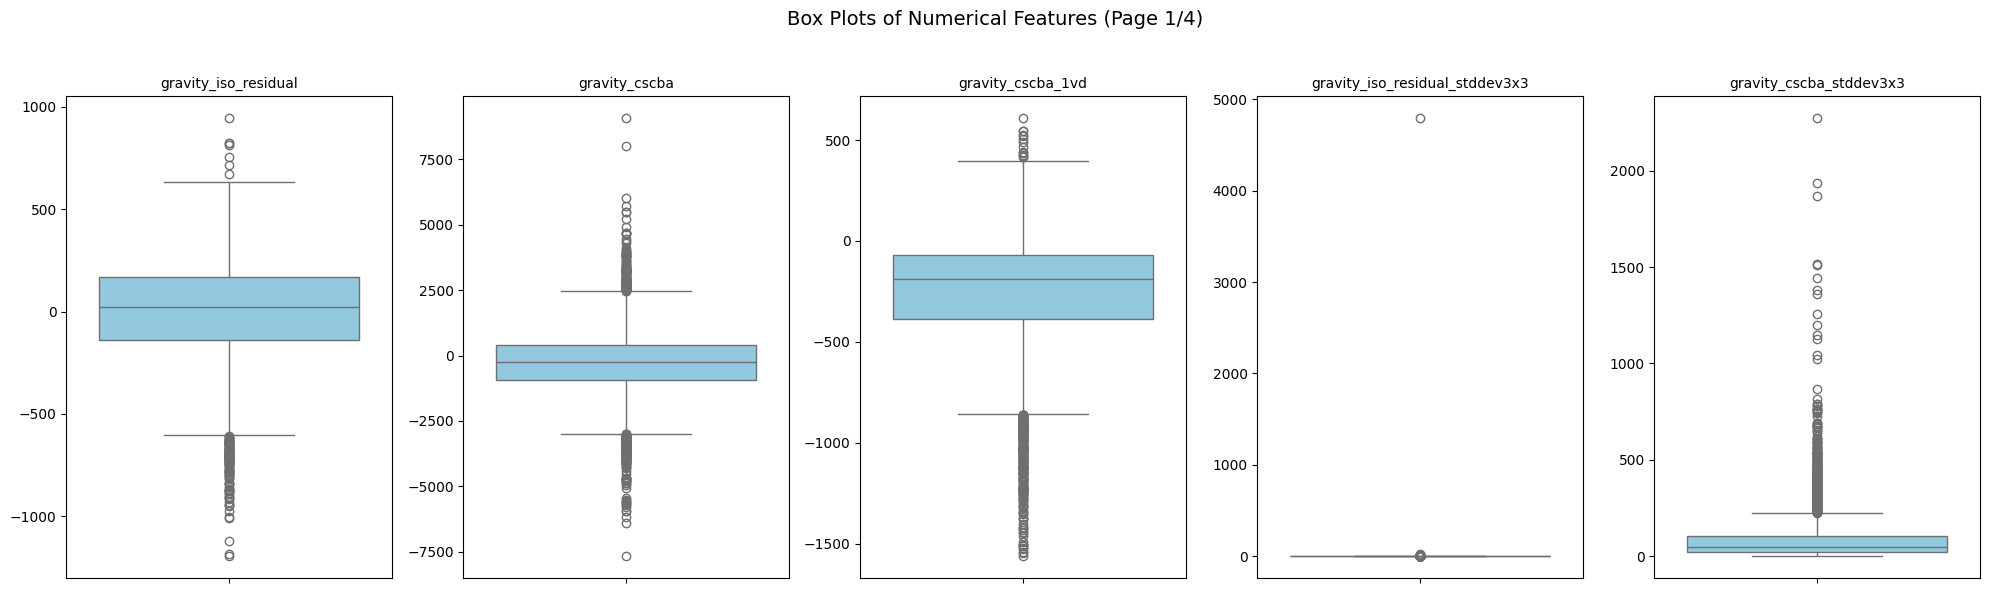

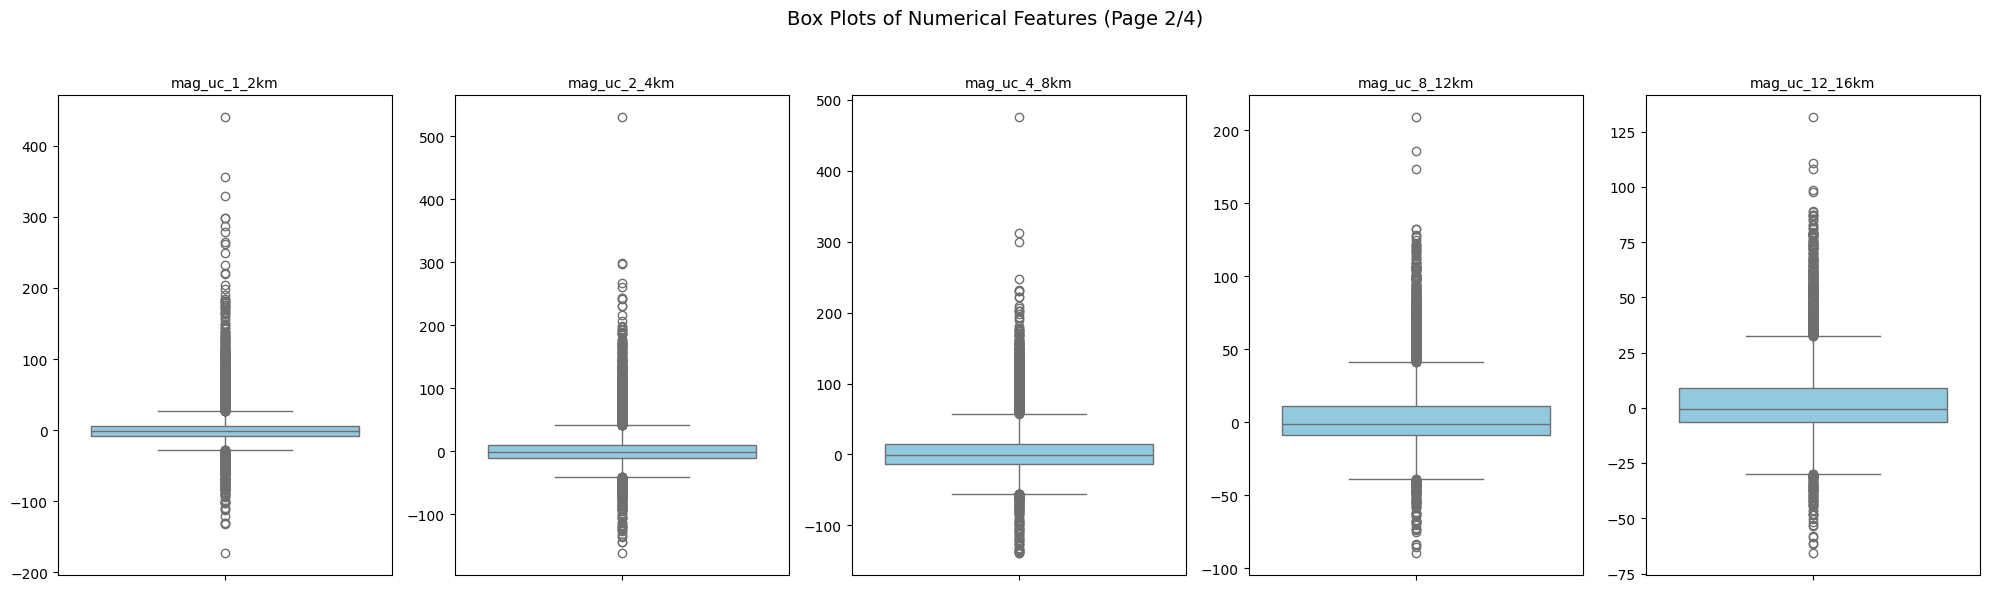

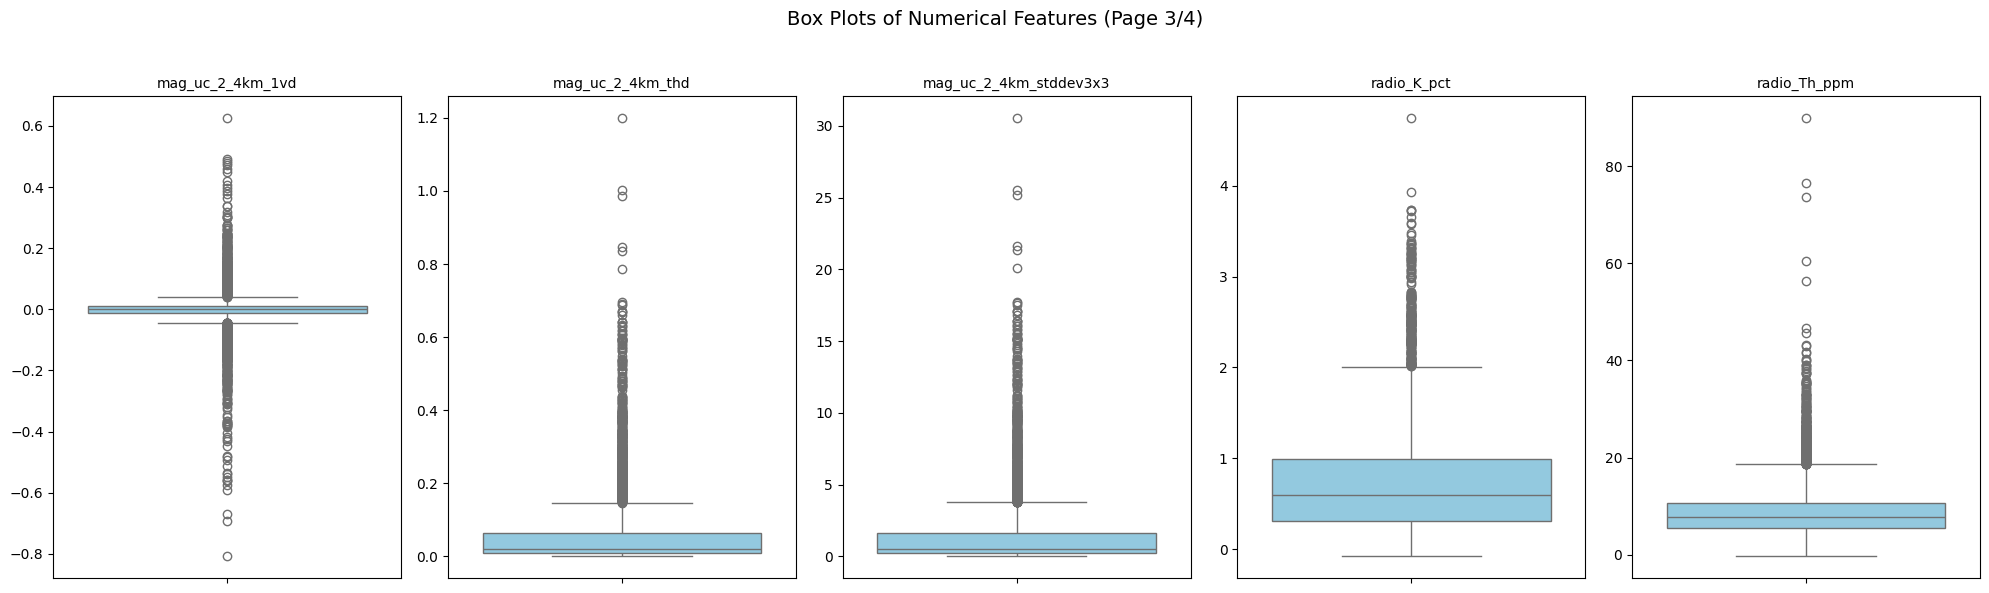

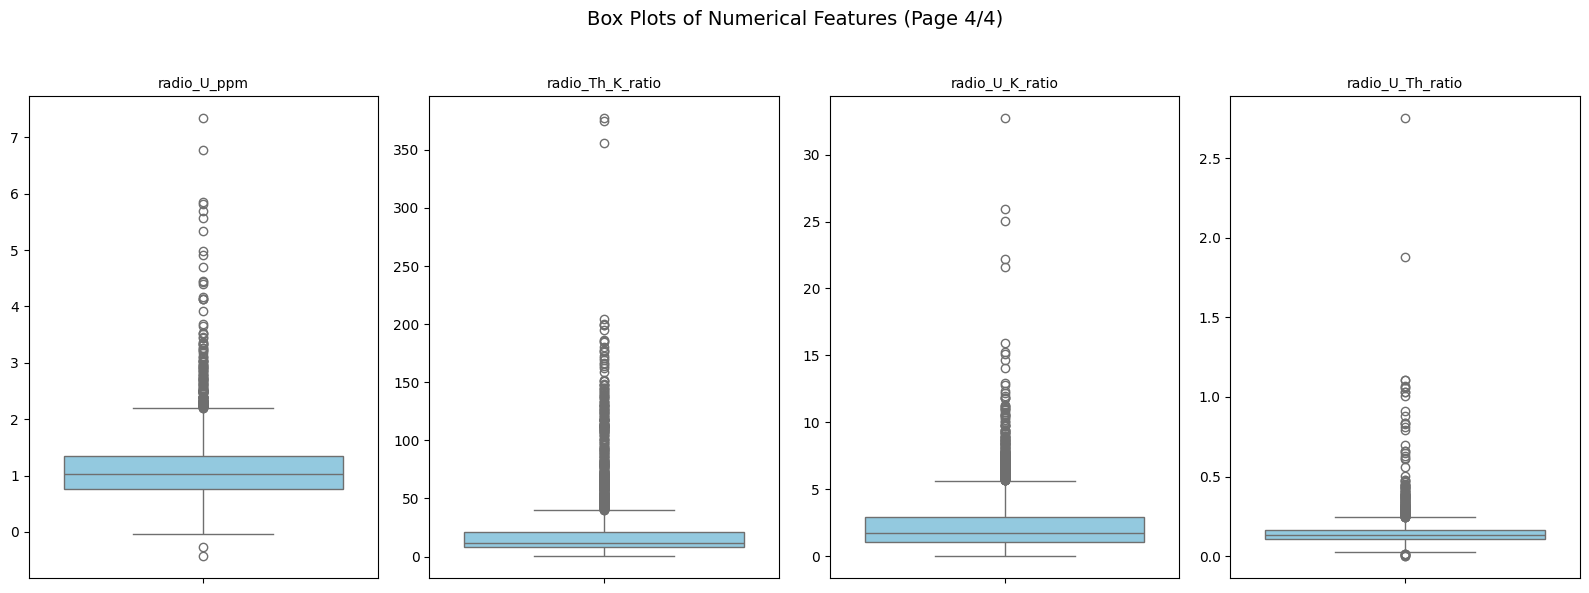

In [14]:
# Box Plots: Visualize spread and identify potential outliers for each feature.

num_cols = feature_cols  
cols_per_page = 5  
n_pages = math.ceil(len(num_cols) / cols_per_page)

for page in range(n_pages):
    start = page * cols_per_page
    end = min((page + 1) * cols_per_page, len(num_cols))
    cols_subset = num_cols[start:end]

    fig, axes = plt.subplots(1, len(cols_subset), figsize=(4 * len(cols_subset), 6), sharey=False)
    
    if len(cols_subset) == 1:
        axes = [axes]
        
    for i, col in enumerate(cols_subset):
        sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    plt.suptitle(f"Box Plots of Numerical Features (Page {page+1}/{n_pages})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


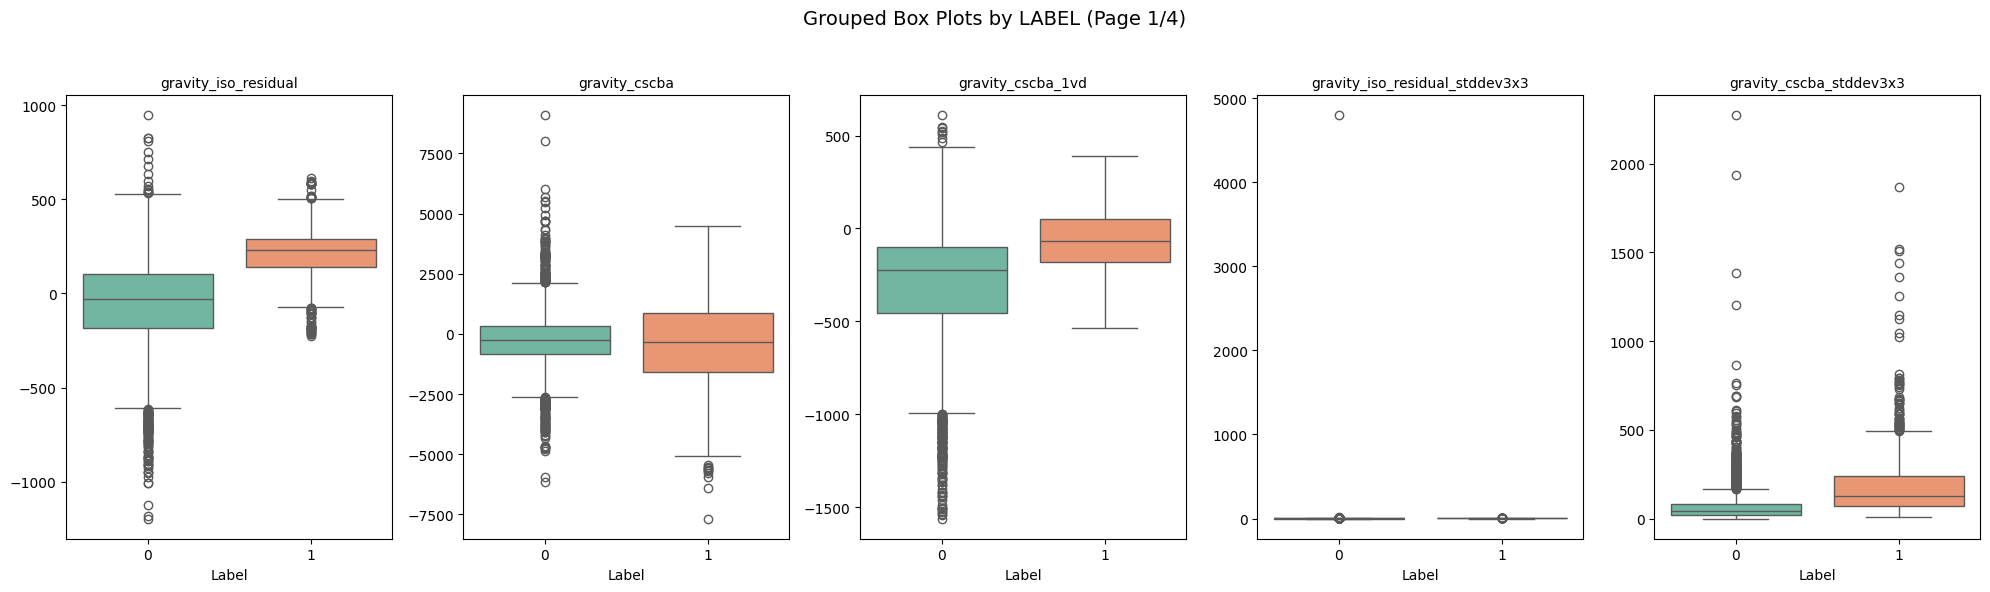

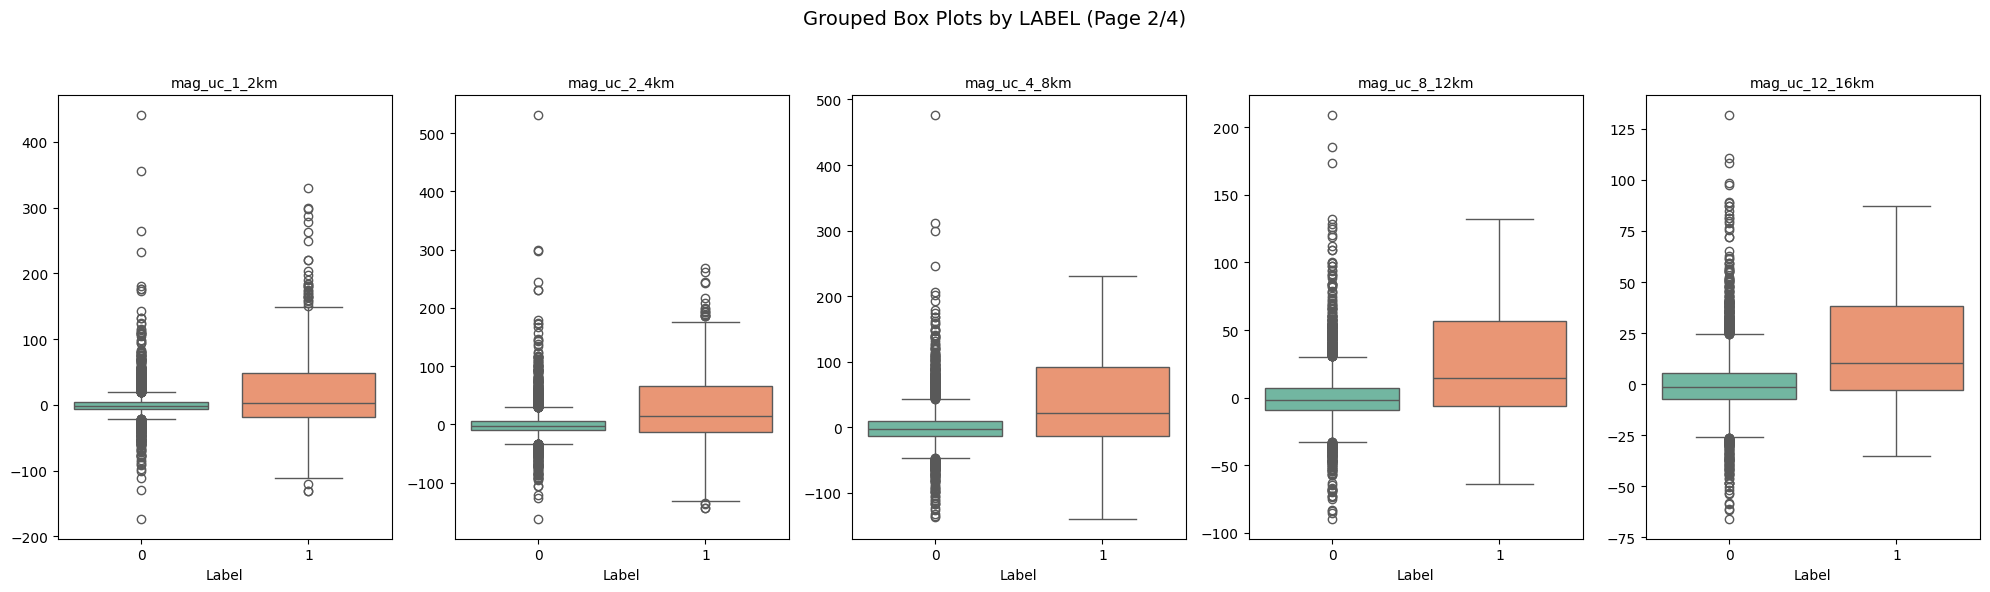

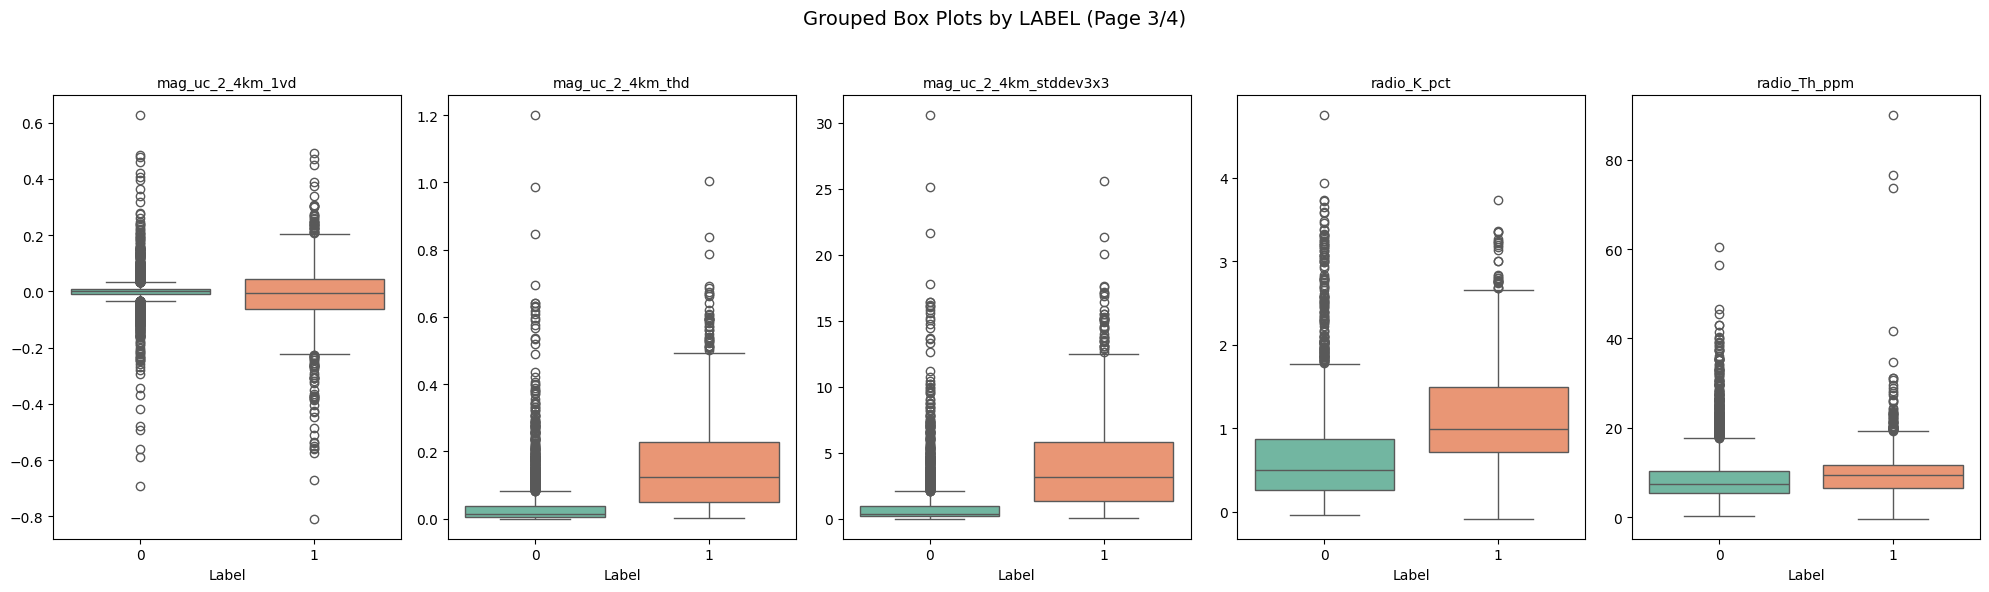

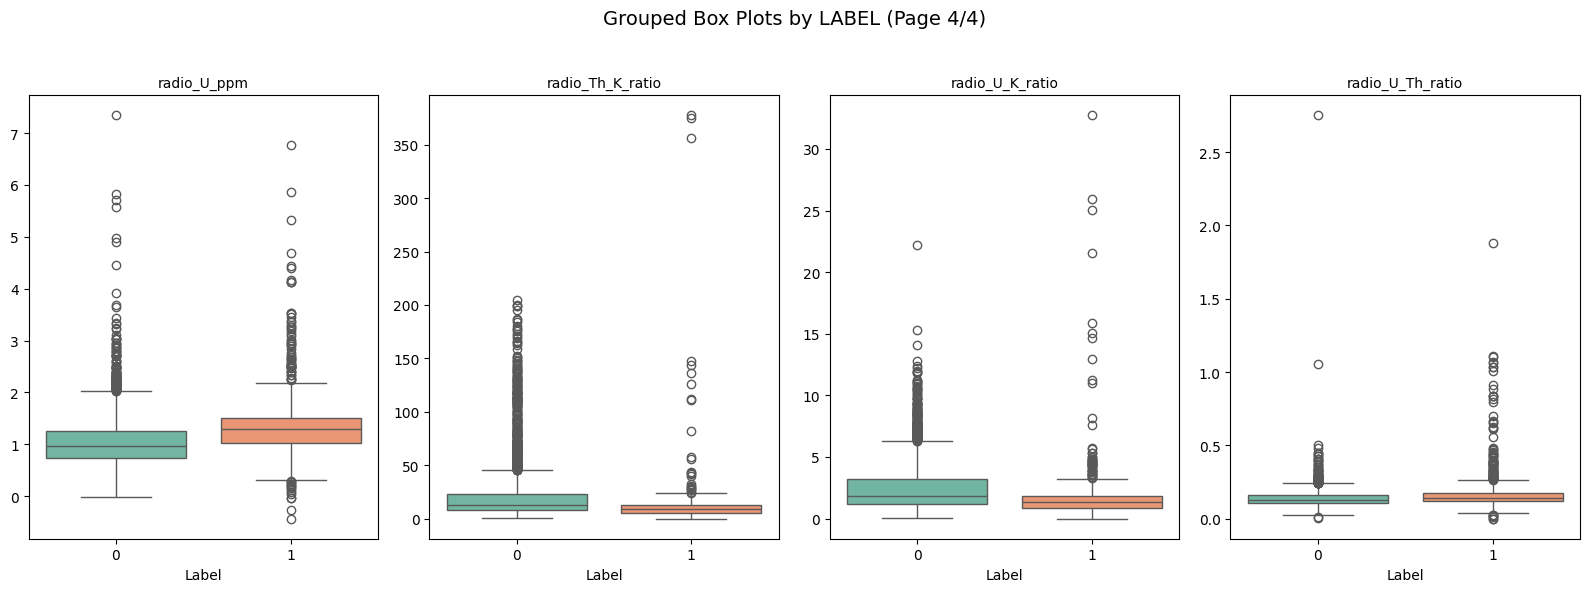

In [15]:
num_cols = feature_cols
cols_per_page = 5
n_pages = math.ceil(len(num_cols) / cols_per_page)

for page in range(n_pages):
    start = page * cols_per_page
    end = min((page + 1) * cols_per_page, len(num_cols))
    cols_subset = num_cols[start:end]

    fig, axes = plt.subplots(1, len(cols_subset), figsize=(4 * len(cols_subset), 6), sharey=False)

    if len(cols_subset) == 1:
        axes = [axes]

    for i, col in enumerate(cols_subset):
        sns.boxplot(data=df, x="LABEL", y=col, hue="LABEL", ax=axes[i], palette="Set2", legend=False)
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("")

    plt.suptitle(f"Grouped Box Plots by LABEL (Page {page+1}/{n_pages})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 3. Correlation Analysis

The correlation heatmap above displays the pairwise Pearson correlation coefficients between all numeric features used in the model training dataset. Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with darker red tones indicating stronger positive relationships and blue tones representing negative ones.

- **Gravity Features**:
  - `gravity_iso_residual` and `gravity_cscba_1vd`: **very high correlation (0.90)**

- **Magnetics Features**:
  - Strong correlations exist among magnetic upward continued grids:
    - `mag_uc_1_2km` ↔ `mag_uc_2_4km`: **0.92**
    - `mag_uc_2_4km` ↔ `mag_uc_4_8km`: **0.92**
    - `mag_uc_4_8km` ↔ `mag_uc_8_12km`: **0.95**
    - `mag_uc_8_12km` ↔ `mag_uc_12_16km`: **0.98**
    - `mag_uc_2_4km_thd` ↔ `mag_uc_2_4km_stddev3x3`: **1**
  - These indicate depth-continuous spatial structure in magnetic anomalies and may lead to multicollinearity in models if not handled.

- **Radiometric Correlations**
  - `radio_Th_ppm`, `radio_U_ppm`, and `radio_Th_K_ratio` show **moderate correlations** with one another (e.g., Th–U: 0.69), consistent with natural elemental co-occurrence.
  - `radio_U_K_ration` and `radio_Th_K_ration` are **strongly correlated**(0.86)


**Highly correlated features** may cause overfitting in linear models or inflate importance scores in tree-based models. Dimensionality reduction or feature selection (e.g., PCA, VIF filtering) may be considered. Alternatively, regularized models (e.g., Lasso, Ridge, or XGBoost) can internally mitigate these effects. Consider combining correlated magnetic features using depth-weighted averaging or principal components.


Text(0.5, 1.0, 'Feature Correlation Matrix')

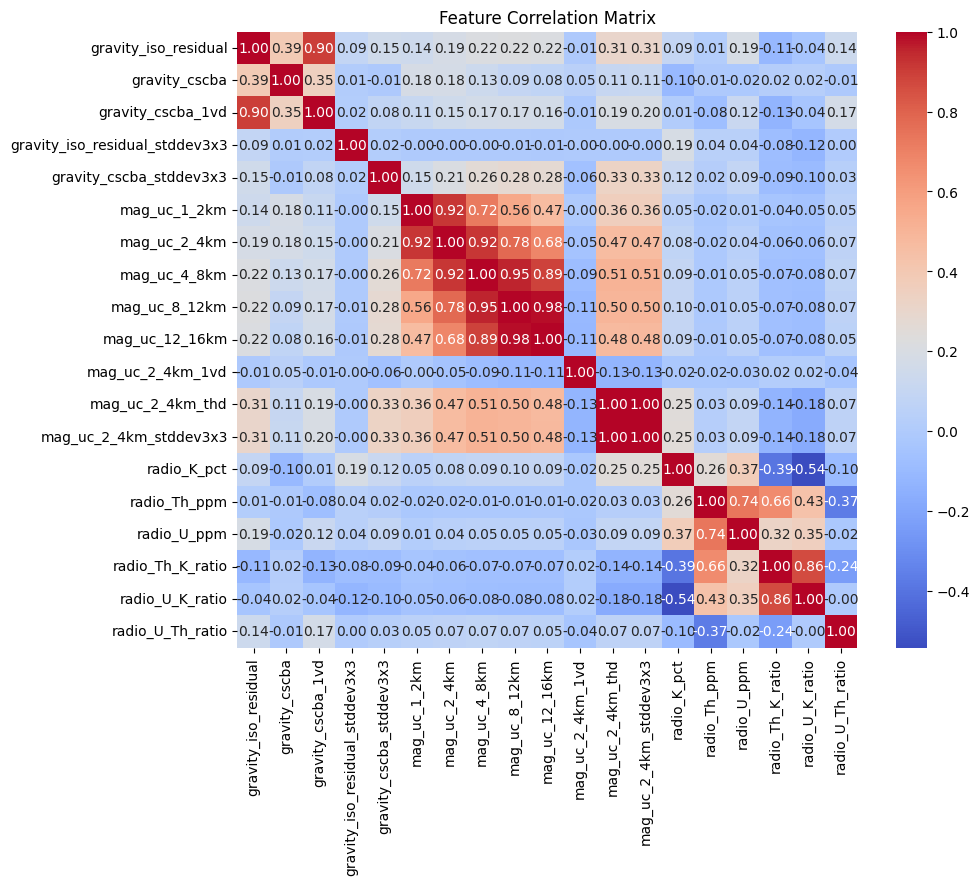

In [16]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[feature_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")

# 4. Data Quality Checks

## 4.1. Missing Values

- **Radiometric features** have the highest number of missing values (229), likely due to no data coverage in specific regions of the raster layer.
- **Gravity features** have minimal missingness and are likely edge effects from raster reprojection or nodata masks.
- Ratios (`*_K_ratio`, `*_Th_ratio`) are also missing whenever their base concentrations are missing.

- **Remove exact duplicate rows** to avoid bias and leakage.
- Apply **median imputation** (or other strategy) to fill missing values **after splitting into training and validation sets**, like:

In [17]:
missing = df.isnull().sum()
missing[missing > 0]

gravity_iso_residual      6
gravity_cscba             1
radio_K_pct             229
radio_Th_ppm            229
radio_U_ppm             229
radio_Th_K_ratio        229
radio_U_K_ratio         229
radio_U_Th_ratio        229
dtype: int64

## 4.2. Duplicate Rows

Drop **duplicate rows** before training.

In [18]:
dupes = df.duplicated().sum()
print(f"Duplicate rows: {dupes}")


Duplicate rows: 10


## 4.3. Constant or Near-Constant Feautres

In [20]:
vt = VarianceThreshold(threshold=0.01)
vt.fit(df.drop(columns=['LABEL']))
low_variance = df.drop(columns=['LABEL']).columns[~vt.get_support()]
print("Low variance features:", list(low_variance))


Low variance features: ['mag_uc_2_4km_1vd', 'radio_U_Th_ratio']


In [21]:
df[['mag_uc_2_4km_1vd', 'radio_U_Th_ratio']].var()

mag_uc_2_4km_1vd    0.005498
radio_U_Th_ratio    0.007516
dtype: float64

# 5. Summary of Exploratory Data Analysis (EDA)

The training dataset consists of a total of **4929 samples**, evenly distributed across three source categories: `positive` (known porphyry copper deposits), `blank_area` (non-mineralized zones). The binary target variable `LABEL` is defined as `1` for porphyry copper and `0` for non-porphyry samples.


# 6. Data Preprocessing Recommendations

Based on the Exploratory Data Analysis (EDA) performed in notebook `30_eda_model_input.ipynb` and considering the project's initial focus (Mode A using Random Forest/Gradient Boosting models), the following preprocessing strategy is recommended:

1.  **Missing Value Treatment:**
    * **Measure:** Use **median imputation** for numerical features with missing values.
    * **Reasoning:** The median is robust to outliers and skewness, which were observed in some features (especially radiometrics) during EDA. (Confirm this step is completed based on notebook `32_..._imputation.ipynb`).

2.  **Outlier Handling:**
    * **Measure:** **Do not drop outliers**. Instead, rely on the chosen scaling method (`RobustScaler`) to mitigate their influence.
    * **Reasoning:** Outliers in geological/geophysical data can represent significant anomalies or valid extreme measurements relevant to mineralization. Dropping them might remove valuable information. `RobustScaler` inherently handles outliers during the scaling process. Log-transformation remains an option for future refinement if needed.

3.  **Feature Scaling:**
    * **Measure:** Apply **`RobustScaler` uniformly** to **all** numerical input features (gravity, magnetics, radiometrics) after handling missing values.
    * **Reasoning:**
        * **Addresses Scale Difference:** Primarily addresses the need to bring physically different measurements (mGal, nT, ppm, %, ratios) onto a comparable scale for the model.
        * **Outlier Robustness:** `RobustScaler` uses median and IQR, making it less sensitive to the outliers and skewness observed in the EDA compared to `StandardScaler`.
        * **Simplicity & Consistency:** Provides a single, consistent pipeline step for all features, simplifying implementation and maintenance.
        * **Model Suitability:** While Random Forest/Gradient Boosting are less sensitive to scaling *type*, ensuring comparable scales is still good practice, and `RobustScaler` handles the observed data characteristics well. Avoids the complexity of `ColumnTransformer` for potentially marginal gains with these models.
    * **Implementation Note:** The `RobustScaler` must be `fit` **only** on the training data split and then saved using `joblib`. This same fitted scaler must be loaded and used to `transform` training, validation, and all new prediction data.

4.  **Feature Selection (Multicollinearity):**
    * **Measure:** For the initial implementation, **defer** explicit feature selection or dimensionality reduction techniques (like PCA) aimed at addressing multicollinearity (observed mainly within magnetic features).
    * **Reasoning:** Random Forest and Gradient Boosting can handle correlated features reasonably well. Addressing this adds complexity better suited for later optimization stages or Mode B. Proceed with all features for now, but be mindful of potential instability in feature importance interpretations for the highly correlated magnetic group.

5.  **Class Balance:**
    * **Measure:** Based on EDA, the current development dataset appears balanced. No immediate action (like SMOTE or class weighting) is required.
    * **Reasoning:** Balancing techniques are only necessary when significant class imbalance exists and negatively impacts model performance. Monitor this if the sampling strategy changes or new datasets are used in the future.
